# ML Demo: Predicting Air Quality w/ ASDI NOAA + OpenAQ Datasets
This demo consists of a Jupyter Notebook that connects to Amazon Sustainability Data Initiative (ASDI) datasets from NOAA and OpenAQ to build a Machine Learning (ML) model to predict air quality levels using weather data via a Binary Classification [AutoGluon](https://auto.gluon.ai/stable/index.html) model. The project's purpose is to demonstrate using two different types of ASDI datasets (files in Amazon S3 and HTTPS APIs) within a Jupyter Notebook, such as provided by Amazon SageMaker Studio Lab. This demo is NOT for scientific or health purposes.

This Jupyter Notebook can be run for free using Amazon SageMaker Studio Lab and open-source Amazon Sustainability Data Initiative (ASDI) datasets without needing an AWS account.

[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws-samples/aws-smsl-predict-airquality-via-weather/blob/main/aq_by_weather.ipynb)

## BACKGROUND: 1 out of 8 deaths in the world is due to poor air quality*
This demo explores correlations between weather and air quality since we know factors like temperatures, wind speeds, etc, affect certain air quality parameters. Predicting air quality can get into highly sophisticated ML techniques, but this demo shows how merging NOAA GSOD weather data with OpenAQ air quality data to build an ML model using AutoGluon (AutoML from AWS) can result in prediction accuracy of ~75-90% using Binary Classification models for various high-pollution areas and air quality parameters (mostly tested for 2.5 micron Particulate Matter and some Ground Level Ozone).\
*Source: [OpenAQ.org](https://OpenAQ.org)

## INSTRUCTIONS
- Configure your environment using the repo's environment.yml file or by running the *pip install* commands below.
- If you want to run this Notebook yourself, first use the _Clear All Outputs_ option.
- CELL #3: Review the Classes and Variables defined in this cell to see defaults and how ASDI access occurs.
- CELL #4: Review the pre-defined AQParams and AQScenarios in this cell. You can edit these and/or add your own.
- CELL #5: Select a scenario via the drop-down to use throughout the Notebook. This will drive the ML process.
- Step through the remaining cells in the Notebook to access data, merge data, and build a Binary Classification Autogluon model.
- NOTE: NOAA and OpenAQ input data is saved locally as CSV files and re-used in order to minimize unnecessary data access and compute resources. Be aware of this feature and clear the local data files, if your intention is to re-fetch the data.

In [1]:
# Set up your environment according to the repo's environment.yml file or run the following...
# Comment these out, once installed or otherwise not needed.
# This creates an empty pip_requirements.txt file used to suppress 'already satisfied' output.
import os
with open('pip_requirements.txt', mode='a'): pass
%pip install boto3        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install pandas       -r pip_requirements.txt | grep -v 'already satisfied'
%pip install numpy        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install requests     -r pip_requirements.txt | grep -v 'already satisfied'
%pip install ipywidgets   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install scikit-learn -r pip_requirements.txt | grep -v 'already satisfied'
%pip install autogluon    -r pip_requirements.txt | grep -v 'already satisfied'
%pip install matplotlib   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install nbconvert    -r pip_requirements.txt | grep -v 'already satisfied'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements for packages used...
import os, glob, shutil, sys, requests, json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from datetime import datetime
from types import SimpleNamespace
from IPython.display import clear_output

# The following is required for matplotlib plots to display in some envs...
%matplotlib inline

In [3]:
# CELL #3: Review the Variables and Classes defined in this cell to see defaults and how ASDI access occurs...

# class AQParam => Used to define attributes for the (6) main OpenAQ parameters.
class AQParam:
    def __init__(self, id, name, unit, unhealthyThresholdDefault, desc):
        self.id                        = id
        self.name                      = name
        self.unit                      = unit
        self.unhealthyThresholdDefault = unhealthyThresholdDefault
        self.desc                      = desc
    
    def isValid(self):
        if(self is not None and self.id > 0 and self.unhealthyThresholdDefault > 0.0 and 
           len(self.name) > 0 and len(self.unit) > 0 and len(self.desc) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQScenario => Defines an ML scenario including a Location w/ NOAA Weather Station ID 
#                     and the target OpenAQ Param.
# Note: OpenAQ data mostly begins sometime in 2016, so using that as a default yearStart value.
class AQScenario:
    def __init__(self, location=None, noaaStationID=None, aqParamTarget=None, unhealthyThreshold=None, 
                 yearStart=2016, yearEnd=2022, aqRadiusMiles=10, featureColumnsToDrop=None):
        self.location           = location
        self.name               = location + "_" + aqParamTarget.name
        self.noaaStationID      = noaaStationID
        self.noaaStationLat     = 0.0
        self.noaaStationLng     = 0.0
        self.openAqLocIDs       = []
        
        self.aqParamTarget      = aqParamTarget
        
        if unhealthyThreshold and unhealthyThreshold > 0.0:
            self.unhealthyThreshold = unhealthyThreshold
        else:
            self.unhealthyThreshold = self.aqParamTarget.unhealthyThresholdDefault
        
        self.yearStart          = yearStart
        self.yearEnd            = yearEnd
        self.aqRadiusMiles      = aqRadiusMiles
        self.aqRadiusMeters     = aqRadiusMiles * 1610 # Rough integer approximation is fine here.
        
        self.modelFolder        = "AutogluonModels"
            
    def getSummary(self):
        return f"Scenario: {self.name} => {self.aqParamTarget.desc} ({self.aqParamTarget.name}) with UnhealthyThreshold > {self.unhealthyThreshold} {self.aqParamTarget.unit}"
    
    def getModelPath(self):
        return f"{self.modelFolder}/aq_{self.name}_{self.yearStart}-{self.yearEnd}/"
    
    def updateNoaaStationLatLng(self, noaagsod_df_row):
        # Use a NOAA row to set Lat+Lng values used for the OpenAQ API requests...
        if(noaagsod_df_row is not None and noaagsod_df_row['LATITUDE'] and noaagsod_df_row['LONGITUDE']):
            self.noaaStationLat = noaagsod_df_row['LATITUDE']
            self.noaaStationLng = noaagsod_df_row['LONGITUDE']
            print(f"NOAA Station Lat,Lng Updated for Scenario: {self.name} => {self.noaaStationLat},{self.noaaStationLng}")
        else:
            print("NOAA Station Lat,Lng COULD NOT BE UPDATED.")
    
    def isValid(self):
        if(self is not None and self.aqParamTarget is not None and
           self.yearStart > 0 and self.yearEnd > 0 and self.yearEnd >= self.yearStart and 
           self.aqRadiusMiles > 0 and self.aqRadiusMeters > 0 and self.unhealthyThreshold > 0.0 and 
           len(self.name) > 0 and len(self.noaaStationID) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQbyWeatherApp => Main app class with settings, AQParams, AQScenarios, and data access methods...
class AQbyWeatherApp:
    def __init__(self, mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy', mlTimeLimitSecs=None):
        self.mlTargetLabel   = mlTargetLabel
        self.mlEvalMetric    = mlEvalMetric
        self.mlTimeLimitSecs = mlTimeLimitSecs
        self.mlIgnoreColumns = ['DATE','NAME','LATITUDE','LONGITUDE','day','unit','average','parameter']
        
        self.defaultColumnsNOAA   = ['DATE','NAME','LATITUDE','LONGITUDE',
                                     'DEWP','WDSP','MAX','MIN','PRCP','MONTH'] # Default relevant NOAA columns
        self.defaultColumnsOpenAQ = ['day','parameter','unit','average']       # Default relevant OpenAQ columns
        
        self.aqParams    = {} # A list to save AQParam objects
        self.aqScenarios = {} # A list to save AQScenario objects
        
        self.selectedScenario = None
    
    def addAQParam(self, aqParam):
        if aqParam and aqParam.isValid():
            self.aqParams[aqParam.name] = aqParam
            return True
        else:
            return False
    
    def addAQScenario(self, aqScenario):
        if aqScenario and aqScenario.isValid():
            self.aqScenarios[aqScenario.name] = aqScenario
            if(self.selectedScenario is None):
                self.selectedScenario = self.aqScenarios[next(iter(self.aqScenarios))] # Default selectedScenario to 1st item.
            return True
        else:
            return False
    
    def getFilenameNOAA(self):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"dataNOAA_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{self.selectedScenario.noaaStationID}.csv"
        else:
            return ""
    
    def getFilenameOpenAQ(self):
        if self and self.selectedScenario and self.selectedScenario.isValid() and len(self.selectedScenario.openAqLocIDs) > 0:
            idString = ""
            for i in range(0, len(self.selectedScenario.openAqLocIDs)):
                idString = idString + str(self.selectedScenario.openAqLocIDs[i]) + "-"
            idString = idString[:-1]
            return f"dataOpenAQ_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{idString}.csv"
        else:
            return ""
    
    def getFilenameOther(self, prefix):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"{prefix}_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}.csv"
    
    def getNoaaDataFrame(self):
        # ASDI Dataset Name: NOAA GSOD
        # ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
        # NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
        # NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
        # Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        noaagsod_df = pd.DataFrame()
        filenameNOAA = self.getFilenameNOAA()

        if os.path.exists(filenameNOAA):
            # Use local data file already accessed + prepared...
            print('Loading NOAA GSOD data from local file: ', filenameNOAA)
            noaagsod_df = pd.read_csv(filenameNOAA)
        else:
            # Access + prepare data and save to a local data file...
            noaagsod_bucket = 'noaa-gsod-pds'
            print(f'Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})...')
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

            for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                key = f'{year}/{self.selectedScenario.noaaStationID}.csv'                                    # Compute the key to get
                csv_obj = s3.get_object(Bucket=noaagsod_bucket, Key=key)                                     # Get the S3 object
                csv_string = csv_obj['Body'].read().decode('utf-8')                                          # Read object contents to a string
                noaagsod_df = pd.concat([noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True) # Use the string to build the DataFrame

            # Perform some Feature Engineering to append potentially useful columns to our dataset... (TODO: Add more to optimize...)
            # It may be true that Month affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
            noaagsod_df['MONTH'] = pd.to_datetime(noaagsod_df['DATE']).dt.month

            # Trim down to the desired key columns... (do this last in case engineered columns are to be removed)
            noaagsod_df = noaagsod_df[self.defaultColumnsNOAA]
            
        return noaagsod_df
        
    def getOpenAqDataFrame(self):
        # ASDI Dataset Name: OpenAQ
        # ASDI Dataset URL : https://registry.opendata.aws/openaq/
        # OpenAQ API Docs  : https://docs.openaq.org/#/v2/
        # OpenAQ S3 data is only organized by date folders, so each folder is large and contains all stations.
        # Because of this, it's better to query ASDI OpenAQ data using the CloudFront-hosted API.
        # Note that some days may not have values and will get filtered out via an INNER JOIN later.
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        aq_df = pd.DataFrame()
        aq_reqUrlBase = "https://api.openaq.org/v2" # OpenAQ ASDI API Endpoint URL Base (ie: add /locations OR /averages)
        
        if self.selectedScenario.noaaStationLat == 0.0 or self.selectedScenario.noaaStationLng == 0.0:
            print("NOAA Station Lat/Lng NOT DEFINED. CANNOT PROCEED")
            return aq_df
        
        if len(self.selectedScenario.openAqLocIDs) == 0:
            # We must start by querying nearby OpenAQ Locations for their IDs...
            print('Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...')
            aq_reqParams = {
                'limit': 10,
                'page': 1,
                'offset': 0,
                'sort': 'desc',
                'order_by': 'location',
                'parameter': self.selectedScenario.aqParamTarget.name,
                'coordinates': f'{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}',
                'radius': self.selectedScenario.aqRadiusMeters,
                'isMobile': 'false',
                'sensorType': 'reference grade',
                'dumpRaw': 'false'
            }
            aq_resp = requests.get(aq_reqUrlBase + "/locations", aq_reqParams)
            aq_data = aq_resp.json()
            if aq_data['results'] and len(aq_data['results']) >= 1:
                for i in range(0, len(aq_data['results'])):
                    self.selectedScenario.openAqLocIDs.append(aq_data['results'][i]['id'])
                print(f"OpenAQ Location IDs within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) " +
                      f"of NOAA Station {self.selectedScenario.noaaStationID} at " +
                      f"{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}: {self.selectedScenario.openAqLocIDs}")
            else:
                print(f"NO OpenAQ Location IDs found within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) " +
                      f"of NOAA Station {self.selectedScenario.noaaStationID}. CANNOT PROCEED.")
        
        if len(self.selectedScenario.openAqLocIDs) >= 1:
            filenameOpenAQ = self.getFilenameOpenAQ()

            if os.path.exists(filenameOpenAQ):
                # Use local data file already accessed + prepared...
                print('Loading OpenAQ data from local file: ', filenameOpenAQ)
                aq_df = pd.read_csv(filenameOpenAQ)
            else:
                # Access + prepare data (NOTE: calling OpenAQ API one year at a time to avoid timeouts)
                print('Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...')

                for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                    aq_reqParams = {
                        'date_from': f'{year}-01-01',
                        'date_to': f'{year}-12-31',
                        'parameter': [self.selectedScenario.aqParamTarget.name],
                        'limit': 366,
                        'page': 1,
                        'offset': 0,
                        'sort': 'asc',
                        'spatial': 'location',
                        'temporal': 'day',
                        'location': self.selectedScenario.openAqLocIDs,
                        'group': 'true'
                    }
                    aq_resp = requests.get(aq_reqUrlBase + "/averages", aq_reqParams)
                    aq_data = aq_resp.json()
                    if aq_data['results'] and len(aq_data['results']) >= 1:
                        aq_df = pd.concat([aq_df, pd.json_normalize(aq_data['results'])], ignore_index=True)

                # Using the joined dataframe, trim down to the desired key columns...
                aq_df = aq_df[self.defaultColumnsOpenAQ]

                # Perform some Label Engineering to add our binary classification label => {0=OKAY, 1=UNHEALTHY}
                aq_df[self.mlTargetLabel] = np.where(aq_df['average'] <= self.selectedScenario.unhealthyThreshold, 0, 1)
        
        return aq_df
    
    def getMergedDataFrame(self, noaagsod_df, aq_df):
        if len(noaagsod_df) > 0 and len(aq_df) > 0:
            merged_df = pd.merge(noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="day")
            merged_df = merged_df.drop(columns=self.mlIgnoreColumns)
            return merged_df
        else:
            return pd.DataFrame()
    
    def getConfusionMatrixData(self, cm):
        cmData = SimpleNamespace()
        cmData.TN = cm[0][0]
        cmData.TP = cm[1][1]
        cmData.FN = cm[1][0]
        cmData.FP = cm[0][1]
        
        cmData.TN_Rate = cmData.TN/(cmData.TN+cmData.FP)
        cmData.TP_Rate = cmData.TP/(cmData.TP+cmData.FN)
        cmData.FN_Rate = cmData.FN/(cmData.FN+cmData.TP)
        cmData.FP_Rate = cmData.FP/(cmData.FP+cmData.TN)
        
        cmData.TN_Output = f"True Negatives  (TN): {cmData.TN} of {cmData.TN+cmData.FP} => {round(cmData.TN_Rate * 100, 2)}%"
        cmData.TP_Output = f"True Positives  (TP): {cmData.TP} of {cmData.TP+cmData.FN} => {round(cmData.TP_Rate * 100, 2)}%"
        cmData.FN_Output = f"False Negatives (FN): {cmData.FN} of {cmData.FN+cmData.TP} => {round(cmData.FN_Rate * 100, 2)}%"
        cmData.FP_Output = f"False Positives (FP): {cmData.FP} of {cmData.FP+cmData.TN} => {round(cmData.FP_Rate * 100, 2)}%"
        
        return cmData
            
print("Classes and Variables are ready.")

Classes and Variables are ready.


In [4]:
# CELL #4: Review the pre-defined AQParams and AQScenarios in this cell. You can edit these and/or use your own...
# AQParams are added with default thresholds, which can be overridden on a per-AQScenario basis.
# These AQParams are based on the OpenAQ /parameters API call where isCore=true (https://api.openaq.org/v2/parameters).
# Default thresholds where provided using data from EPA.gov (https://www.epa.gov/criteria-air-pollutants/naaqs-table).
# Confirm and adjust params or thresholds as needed for your needs... Not for scientific or health purposes.

# Instantiate main App class with explicit mlTargetLabel and mlEvalMetric provided...
AQbyWeather = AQbyWeatherApp(mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy')

# Define and add new AQParams...
AQbyWeather.addAQParam(AQParam( 1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers"))
AQbyWeather.addAQParam(AQParam( 2, "pm25", "µg/m³",  12.0, "Particulate Matter < 2.5 micrometers"))
AQbyWeather.addAQParam(AQParam( 7, "no2",  "ppm",   100.0, "Nitrogen Dioxide"))
AQbyWeather.addAQParam(AQParam( 8, "co",   "ppm",     9.0, "Carbon Monoxide"))
AQbyWeather.addAQParam(AQParam( 9, "so2",  "ppm",    75.0, "Sulfur Dioxide"))
AQbyWeather.addAQParam(AQParam(10, "o3",   "ppm",   0.070, "Ground Level Ozone"))

# Define available AQ Scenarios for certain locations with their associated NOAA GSOD StationID values...
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# TODO: Someday consider how to OPTIONALLY append more scenarios via an optional JSON file
#       (ie: without adding a dependecy outside the .ipynb file)
# NOTE: For Ozone Scenarios, we're generally using 0.035 ppm to override the default threshold.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm10"], None)) # Attempt at pm10 prediction.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fairbanks",   "70261026411", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("lahore-pk",   "41640099999", AQbyWeather.aqParams["pm25"], None))

print(f"AQbyWeather.aqParams: {str(len(AQbyWeather.aqParams))}")
print(f"AQbyWeather.aqScenarios: {str(len(AQbyWeather.aqScenarios))} (Default Selected: {AQbyWeather.selectedScenario.name})")

AQbyWeather.aqParams: 6
AQbyWeather.aqScenarios: 15 (Default Selected: bakersfield_pm25)


In [5]:
# CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
# A default "value" is set to avoid issues. Change this default to run the Notebook from start-to-finish for that Scenario.
print("*** CHOOSE YOUR OWN ADVENTURE HERE ***")
print("Please select a Scenario via the following drop-down-list...")
print("(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(options=AQbyWeather.aqScenarios.keys(), 
                       value=AQbyWeather.aqScenarios["bakersfield_pm25"].name) # <-- DEFAULT / FULL-RUN VALUE
ddl

*** CHOOSE YOUR OWN ADVENTURE HERE ***
Please select a Scenario via the following drop-down-list...
(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)


Dropdown(options=('bakersfield_pm25', 'bakersfield_pm10', 'bakersfield_o3', 'fresno_pm25', 'fresno_o3', 'visal…

In [6]:
if ddl.value:
    AQbyWeather.selectedScenario = AQbyWeather.aqScenarios[ddl.value]
    print(AQbyWeather.selectedScenario.getSummary())
    print(AQbyWeather.selectedScenario.toJSON())
else:
    print("Please select a Scenario via the above drop-down-list.")

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
{
  "aqParamTarget": {
    "desc": "Particulate Matter < 2.5 micrometers",
    "id": 2,
    "name": "pm25",
    "unhealthyThresholdDefault": 12.0,
    "unit": "\u00b5g/m\u00b3"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "location": "bakersfield",
  "modelFolder": "AutogluonModels",
  "name": "bakersfield_pm25",
  "noaaStationID": "72384023155",
  "noaaStationLat": 0.0,
  "noaaStationLng": 0.0,
  "openAqLocIDs": [],
  "unhealthyThreshold": 12.0,
  "yearEnd": 2022,
  "yearStart": 2016
}


In [7]:
# GET NOAA GSOD WEATHER DATA...
print(AQbyWeather.selectedScenario.getSummary())
noaagsod_df = AQbyWeather.getNoaaDataFrame()

if(len(noaagsod_df) >= 1):
    # Update NOAA Station Lat/Lng...
    AQbyWeather.selectedScenario.updateNoaaStationLatLng(noaagsod_df.iloc[0])
    
    # Save DataFrame to CSV...
    noaagsod_df.to_csv(AQbyWeather.getFilenameNOAA(), index=False)

    # Output DataFrame properties...
    print('noaagsod_df.shape =', noaagsod_df.shape)
    display(noaagsod_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
NOAA Station Lat,Lng Updated for Scenario: bakersfield_pm25 => 35.4344,-119.0542
noaagsod_df.shape = (2346, 10)


,DATE,NAME,LATITUDE,LONGITUDE,DEWP,WDSP,MAX,MIN,PRCP,MONTH
0,2016-01-01,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,29.2,3.0,55.0,27.0,0.0,1
1,2016-01-02,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.8,2.4,57.0,27.0,0.0,1
2,2016-01-03,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.6,4.3,68.0,34.0,0.0,1
3,2016-01-04,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.0,4.9,68.0,39.0,0.0,1
4,2016-01-05,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,42.8,4.5,64.9,42.1,0.0,1
...,...,...,...,...,...,...,...,...,...,...
2341,2022-06-04,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,50.5,7.3,91.0,64.0,0.0,6
2342,2022-06-05,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,45.1,6.4,90.0,63.0,0.0,6
2343,2022-06-06,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,58.7,7.5,90.0,63.0,0.0,6
2344,2022-06-07,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,47.8,5.4,91.0,66.0,0.0,6


In [8]:
# GET OPENAQ AIR QUALITY DAILY AVERAGES DATA...
print(AQbyWeather.selectedScenario.getSummary())
aq_df = AQbyWeather.getOpenAqDataFrame() # Gets nearby Location IDs THEN gets associated daily averages.
    
if len(aq_df) > 0:
    # Output DataFrame properties...
    print('aq_df.shape =', aq_df.shape)
    display(aq_df)
    aq_df.to_csv(AQbyWeather.getFilenameOpenAQ(), index=False)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...
OpenAQ Location IDs within 10 miles (16100m) of NOAA Station 72384023155 at 35.4344,-119.0542: [6885, 28777, 6883, 230814, 887]
Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...
aq_df.shape = (2195, 5)


,day,parameter,unit,average,isUnhealthy
0,2016-03-06,pm25,µg/m³,2.0000,0
1,2016-03-10,pm25,µg/m³,10.5000,0
2,2016-03-11,pm25,µg/m³,5.4286,0
3,2016-03-12,pm25,µg/m³,4.1667,0
4,2016-03-13,pm25,µg/m³,6.0000,0
...,...,...,...,...,...
2190,2022-06-10,pm25,µg/m³,9.2045,0
2191,2022-06-11,pm25,µg/m³,9.4583,0
2192,2022-06-12,pm25,µg/m³,6.1667,0
2193,2022-06-13,pm25,µg/m³,3.5435,0


## Merging the NOAA and OpenAQ data into one dataframe...
We'll be using Autogluon's [_TabularPredictor_](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) on this merged dataframe to predict our target label column. For best results, we need to ensure we have enough data and that we have enough of each target label classification {0,1}.

Review the shape of the merged_df table and the target label bar chart to determine if you have enough data and enough variation in the target label. Ideally, we should have thousands of total rows and at least hundreds of each class value.

In the following cell, we can also visualize correlations between different columns in our merged_df table.

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
merged_df.shape = (2184, 7)


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy
0,47.3,6.8,72.0,51.1,0.02,3,0
1,44.8,3.7,82.9,44.1,0.00,3,0
2,42.8,6.9,82.9,48.0,0.00,3,0
3,43.2,2.5,73.0,45.0,0.23,3,0
4,43.5,3.8,66.9,45.0,0.00,3,0
...,...,...,...,...,...,...,...
2179,50.5,7.3,91.0,64.0,0.00,6,0
2180,45.1,6.4,90.0,63.0,0.00,6,0
2181,58.7,7.5,90.0,63.0,0.00,6,0
2182,47.8,5.4,91.0,66.0,0.00,6,0


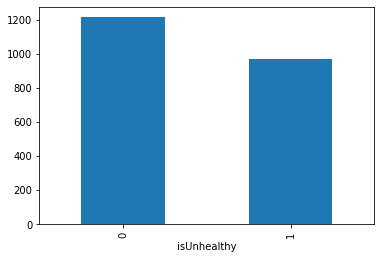

In [9]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
# This column removal will NOT be necessary once we can use Autogluon ignore_columns param (TBD).
print(AQbyWeather.selectedScenario.getSummary())
merged_df = AQbyWeather.getMergedDataFrame(noaagsod_df, aq_df)

if(len(merged_df > 0)):
    # Output DataFrame properties...
    print('merged_df.shape =', merged_df.shape)
    display(merged_df)
    merged_df.groupby([AQbyWeather.mlTargetLabel]).size().plot(kind="bar")
    merged_df.to_csv(AQbyWeather.getFilenameOther("dataMERGED"), index=False)

# TODO: Explore other ways to join the data and/or handle null values...

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


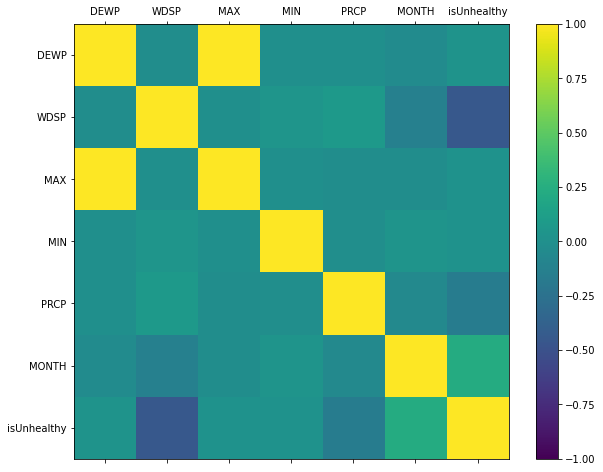

In [10]:
# Visualize correlations in our merged dataframe...
print(AQbyWeather.selectedScenario.getSummary())
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

## Begin ML on Merged Dataframe...
In order to build, validate, and test our ML model, we'll begin by creating three dataframes:
1. **train_df:** This is split from the full merged_df data as the larger chunk and used for training.
2. **validate_df:** This is split from the full merged_df data as the smaller chunk and used for validation.
3. **test_df:** This is the validation dataframe, but with the true target label values removed to enable model testing.

In [11]:
# Additional import statements for autogluon+sklearn and split out train_df + validate_df data...
print(AQbyWeather.selectedScenario.getSummary())
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.33, random_state=1)
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Number of training samples: 1463
Number of validation samples: 721


In [12]:
# Create the test_df data and remove the target label column...
print(AQbyWeather.selectedScenario.getSummary())
test_df=validate_df.drop([AQbyWeather.mlTargetLabel], axis=1)
display(test_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,DEWP,WDSP,MAX,MIN,PRCP,MONTH
241,41.9,4.7,89.1,55.0,0.00,11
994,40.8,2.5,62.1,37.9,0.00,1
1820,42.2,5.5,90.0,63.0,0.00,5
1442,50.0,4.3,73.9,52.0,0.06,4
596,39.7,2.7,66.0,39.9,0.00,12
...,...,...,...,...,...,...
849,53.0,5.5,93.0,64.0,0.00,8
208,37.2,5.6,91.9,57.9,0.00,10
288,37.1,2.8,66.0,36.0,0.00,12
1226,39.3,6.8,99.0,62.1,0.00,9


## Run AutoGluon TabularPredictor.fit(...)
- Instantiate TabularPredictor with explicit values for label, eval_metric, and path.
- Call TabularPredictor.fit(...) using our train_df tabular data as the main input.

In [13]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
predictor = TabularPredictor(label=AQbyWeather.mlTargetLabel, 
                             eval_metric=AQbyWeather.mlEvalMetric, 
                             path=AQbyWeather.selectedScenario.getModelPath())
predictor.fit(train_data=train_df, time_limit=AQbyWeather.mlTimeLimitSecs, verbosity=2, presets='best_quality')

'Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³'

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_bakersfield_pm25_2016-2022/"
AutoGluon Version:  0.4.2
Python Version:     3.9.13
Operating System:   Linux
Train Data Rows:    1463
Train Data Columns: 6
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15321.24 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set

## Evaluating Our Autogluon Model...
- Use TabularPredictor.feature_importance(...) with our validation_df to get feature importance data.\
  (this data is displayed further below)
- Use TabularPredictor.leaderboard(...) with our validation_df to get individual model performance data.\
  (this data is displayed further below)
- Display TabularPredictor.evaluate(...) to output various model quality characteristics.

In [14]:
# Get dataframes for feature importance + model leaderboard AND get+display model evaluation...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
featureimp_df   = predictor.feature_importance(validate_df)
leaderboard_df  = predictor.leaderboard(validate_df, silent=True)
modelEvaluation = predictor.evaluate(validate_df, auxiliary_metrics=True)

'Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³'

Computing feature importance via permutation shuffling for 6 features using 721 rows with 5 shuffle sets...
	63.95s	= Expected runtime (12.79s per shuffle set)
	15.71s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.7947295423023578
Evaluations on test data:
{
    "accuracy": 0.7947295423023578,
    "balanced_accuracy": 0.7923707440100882,
    "mcc": 0.5820230438897135,
    "roc_auc": 0.874984237074401,
    "f1": 0.7620578778135049,
    "precision": 0.7476340694006309,
    "recall": 0.7770491803278688
}


In [15]:
# View Autogluon Individual Model Leaderboard...
print(AQbyWeather.selectedScenario.getSummary())
display(leaderboard_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L2,0.812760,0.828435,1.367442,1.244300,75.653306,0.148462,0.127412,11.780471,2,True,24
1,RandomForestEntr_BAG_L2,0.804438,0.832536,1.344696,1.265710,64.646867,0.125717,0.148821,0.774032,2,True,18
2,ExtraTreesGini_BAG_L2,0.803051,0.818865,1.352479,1.281073,64.600034,0.133500,0.164185,0.727199,2,True,20
3,LightGBMXT_BAG_L1,0.801664,0.837321,0.072428,0.043975,5.381871,0.072428,0.043975,5.381871,1,True,3
4,WeightedEnsemble_L2,0.801664,0.837321,0.074507,0.046960,6.365828,0.002078,0.002985,0.983958,2,True,14
5,CatBoost_BAG_L2,0.801664,0.844156,1.232805,1.160382,75.556857,0.013825,0.043494,11.684022,2,True,19
6,XGBoost_BAG_L2,0.801664,0.847573,1.281233,1.191477,70.239682,0.062253,0.074588,6.366847,2,True,23
7,LightGBMLarge_BAG_L2,0.801664,0.840055,1.448996,1.226459,77.812670,0.230016,0.109571,13.939835,2,True,25
8,NeuralNetFastAI_BAG_L2,0.801664,0.832536,1.493159,1.346558,76.021008,0.274179,0.229669,12.148173,2,True,22
9,LightGBMXT_BAG_L2,0.800277,0.840055,1.286816,1.161328,70.349639,0.067837,0.044440,6.476804,2,True,15


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,importance,stddev,p_value,n,p99_high,p99_low
WDSP,0.110125,0.022908,0.000212,5,0.157293,0.062957
MONTH,0.102913,0.012382,0.000025,5,0.128408,0.077418
MAX,0.051318,0.003923,0.000004,5,0.059395,0.043240
PRCP,0.033564,0.005668,0.000094,5,0.045235,0.021894
MIN,0.014147,0.007685,0.007328,5,0.029970,-0.001676
DEWP,0.009986,0.008459,0.028801,5,0.027404,-0.007432


<AxesSubplot:xlabel='feature'>

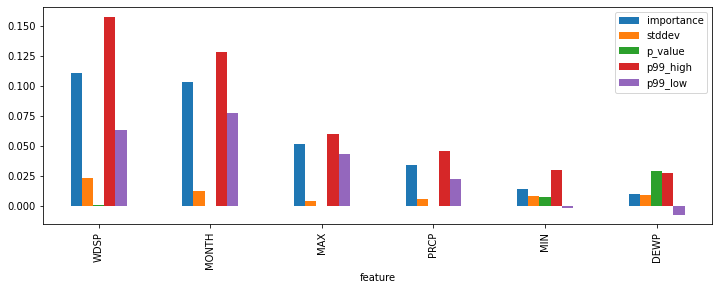

In [16]:
# View and Plot Feature Importance... (this various from Scenario to Scenario)
print(AQbyWeather.selectedScenario.getSummary())
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

## Using + Testing Our Model...
Now that we've built our Autogluon ML Model, we can use our test_df dataframe to make actual target label predictions and then compare those predictions against the known true label values to determine how the model is performing across each binary classification { 0=OKAY, 1=Unhealthy }.  Further below, we'll plot a _Confusion Matrix_ and the **Summary** explains how to interpret results and covers **Key Learnings**.

In [17]:
# Load + Use Our Model (this line is unnecessary, but shows how to load a built model)...
predictor = TabularPredictor.load(AQbyWeather.selectedScenario.getModelPath())

# Make Predictions, which are saved to an array: y_pred
print(AQbyWeather.selectedScenario.getSummary())
y_pred = predictor.predict(test_df)
display(y_pred)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


241     1
994     1
1820    0
1442    0
596     1
       ..
849     0
208     1
288     1
1226    0
2129    0
Name: isUnhealthy, Length: 721, dtype: int64

In [18]:
# Get true label values as an array: y_true
print(AQbyWeather.selectedScenario.getSummary())
y_true = validate_df[AQbyWeather.mlTargetLabel]
display(y_true)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


241     1
994     1
1820    0
1442    0
596     1
       ..
849     1
208     1
288     1
1226    0
2129    0
Name: isUnhealthy, Length: 721, dtype: int64

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
True Negatives  (TN): 336 of 416 => 80.77%
True Positives  (TP): 237 of 305 => 77.7%
False Negatives (FN): 68 of 305 => 22.3%
False Positives (FP): 80 of 416 => 19.23%


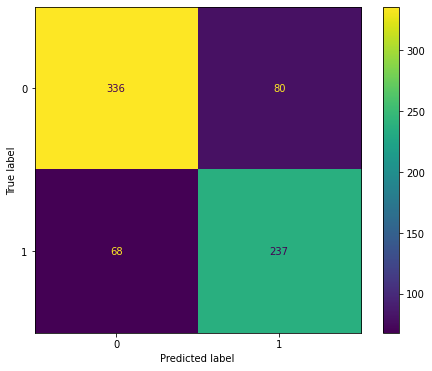

In [19]:
# Get Confusion Matrix (CM), Get Additional CM Data, View CM...
# Learn More: https://towardsdatascience.com/confusion-matrix-what-is-it-e859e1bbecdc
#             https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
print(AQbyWeather.selectedScenario.getSummary())
cm = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix data...
cmData = AQbyWeather.getConfusionMatrixData(cm)
print(cmData.TN_Output)
print(cmData.TP_Output)
print(cmData.FN_Output)
print(cmData.FP_Output)

# Plot Confusion Matrix...
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

## SUMMARY...
This demo showed how to use a SageMaker Studio Lab Jupyter Notebook to connect to open-source Amazon Sustainability Data Initiative (ASDI) datasets both via Amazon S3 (for NOAA weather data) and via HTTPS API (for OpenAQ air quality averages). The NOAA weather data and OpenAQ measurement averages are merged into a single table with irrelevant features dropped. This table is then used to build an Autogluon [TabularPredictor](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) ML model to predict a binary classification { 0=OKAY, 1=Unhealthy } based on weather features.

### Key Learnings
- The relationship between weather and air quality varies geographically and this was confirmed.
  - Feature Importance review shows differing factors in models built for different locations.
  - Academic research indicates the relationship can change by season and an engineered “MONTH” feature was important for most models.
  - An engineered “DAYOFWEEK” feature was expected to be important, but observed correlation was minimal and removing the feature improved most models.
- Predicting a target measurement was infeasible, but predicting a binary “OKAY” vs “unhealthy” classification based on threshold values yielded decent results (~75-90% accuracy metrics).
- For more on production-level air quality predictions, research how climatology and deeper statistical analysis are merged into 3D models that incorporate emissions models, meteorological models, and chemical models.

### Confusion Matrix and Saving Final Results
The Confusion Matrix above plots the relationships between:
- True Positives (1=>1; see bottom-right)
- True Negatives (0=>0; see top-left)
- False Positives (1=>0; see top-right)
- False Negatives (0=>1; see bottom-left)

_The validation dataframe with predictions appended as the final column are saved below as a CSV for additional analysis._

In [20]:
# Create and save final results...
print(AQbyWeather.selectedScenario.getSummary())
resultsFile = AQbyWeather.getFilenameOther("dataRESULTS")
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(resultsFile, index=False)
print(f"Results saved to {resultsFile}. DONE.")
display(results_df)

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Results saved to dataRESULTS_bakersfield_pm25_2016-2022.csv. DONE.


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy,PREDICTION
241,41.9,4.7,89.1,55.0,0.00,11,1,1
994,40.8,2.5,62.1,37.9,0.00,1,1,1
1820,42.2,5.5,90.0,63.0,0.00,5,0,0
1442,50.0,4.3,73.9,52.0,0.06,4,0,0
596,39.7,2.7,66.0,39.9,0.00,12,1,1
...,...,...,...,...,...,...,...,...
849,53.0,5.5,93.0,64.0,0.00,8,1,0
208,37.2,5.6,91.9,57.9,0.00,10,1,1
288,37.1,2.8,66.0,36.0,0.00,12,1,1
1226,39.3,6.8,99.0,62.1,0.00,9,0,0


## Thanks and Clean-up...
**Thanks for your time! I hope this demo was insightful...**

If you'd like to clean up locally generated files, change _isCleanupTime_ to **True** below and run the cell.

The End.

In [21]:
# OPTIONAL: Clean Up Generated Files...
isCleanupTime = False
if(isCleanupTime):
    # Remove local Autogluon Models + Folder...
    shutil.rmtree(AQbyWeather.selectedScenario.modelFolder)
    
    # Remove local CSV data files...
    for filename in glob.glob("*.csv"):
        os.remove(filename)